# Analysis of the Gnutella Network

Gnutella was a p2p file sharing network from the early 2000s.
The network functioned as a distributed alternative to
centralised file indexes, meaning it's purpose was to allow file querying,
i.e. answering the question: "is this file available on a computer
somewhere on the network and, if so, where?"

Thus "Gnutella" refers to at least two interesting networks:
- The network connections between computers allowing for this type of querying.
- The network of who downloaded what file from whom.

Our network is the former: Nodes are consumer laptops and desktops,
and edges are connections between these, representing paths through which
file request queries could move. The edges are directed (each computer had
a list of computers to which it would relay queries). With this in mind we
posed the following question of our data: **how robust is the Gnutella
network?**

We believe robustness is a relevant aspect of the network due to it
being an indication of how useful the network was and how hard
it would be to shut down (much of the activity on the network was
illegal file sharing). The latter we attempt to answer by performing attacks
on the network based on various metrics.

Our data consists of nine snapshots of the Gnutella network, crawled at different
days of August 2002, totalling to more than 190.000 nodes and about
500.000 edges. So as to make analysis more viable with the size of the
network in mind, we precomputed various network properties and stored
the results into .json files for quick use.

<a id='contents'></a>
## Table of Contents
- [Imports](#mports)
- [Json Data](#reading)
- [Analysis](#analysis)
    - [Degree Distribution](#degdist)
    - [Centrality](#centrality)
        - [Betweenness Centrality](#betweenness)
        - [Closeness Centrality](#closeness)
        - [Eigenvector Centrality](#eigenvector)
    - [Fitting](#fitting)
    - [Robustness](#robustness)
- [Future Work](#future)



<a id='imports'></a>

## Imports

The following libraries were used in our analysis:

In [66]:
# native python
import json
import os
import warnings
import sys; sys.path.append('../bin/')

# third party
from tqdm import tqdm
import powerlaw
import numpy as np
import networkx as nx

# plotting
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

<a id='reading'></a>
## Json Data

We construct .json files for each of the 9 graphs. The .json files each contains a dictionary of pre-computed properties. The schema for each dictionary file is as follows:

We load each .json file into a dictionary of dictionaries calling it `D`:

In [67]:
recompute = False        # set to True to recompute json files. Will take a long time

def compute():
    os.system('python ../bin/metrics.py')

def use_json():
    D = {}
    dumps = [f"../data/dumps/{target}" for target in sorted(os.listdir('../data/dumps/'))]
    for i in range(len(dumps)):
        with open(dumps[i], 'r') as data_file:
            data = json.load(data_file)
            D[i] = data
    return D

compute() if recompute else None

D = use_json()

We also constuct a dictioanry of actual networkx graph objects and call it `S`:

In [69]:
path = '../data/graphs/'
targets = [path + target for target in os.listdir(path)]
S = {idx: nx.read_edgelist(target, delimiter="\t", create_using=nx.DiGraph(name='test')) \
     for idx, target in enumerate(targets)}
for idx, G in enumerate(S):
    S[G].name = targets[idx][-6:-4] + '-08-2002'

<a id='analysis'></a>
## Analysis

Initially we perform some exploratory data analysis,
plotting degree distributions, centrality measures,
as well power law fittings. This is done to get a better
understanding the overall structure of the network,
as well as provding context through which
to understand the attack analysis.


Lastly we plot the network robustness by removing nodes using various heuristics (randomly, by degree, etc.).

As our network is in fact nine snapshots of Gnutella
at different points in time, our plots will consist of 9
subplots each, so as to determine what seems remain true across
time and what does not.

With this intention in mind we create a plotter function that
we will use through out this notebook:

In [167]:
def plotter(plot_specific_execution):
    fig, axes = plt.subplots(3, 3, figsize=(16, 16))  # create 3 x 3 subplots
    i = 0                                             # incimenter to loop though all 9 graph data
    for ax in axes:
        for ay in ax:
            exec(f"{plot_specific_execution}")                       # plot specific function call
            ay.legend(); ay.set_title(S[i].name)
            i += 1
    plt.show()

<a id='degdist'></a>
### Degree distribution

We plot the degree distribution of each graph in a loglog plot

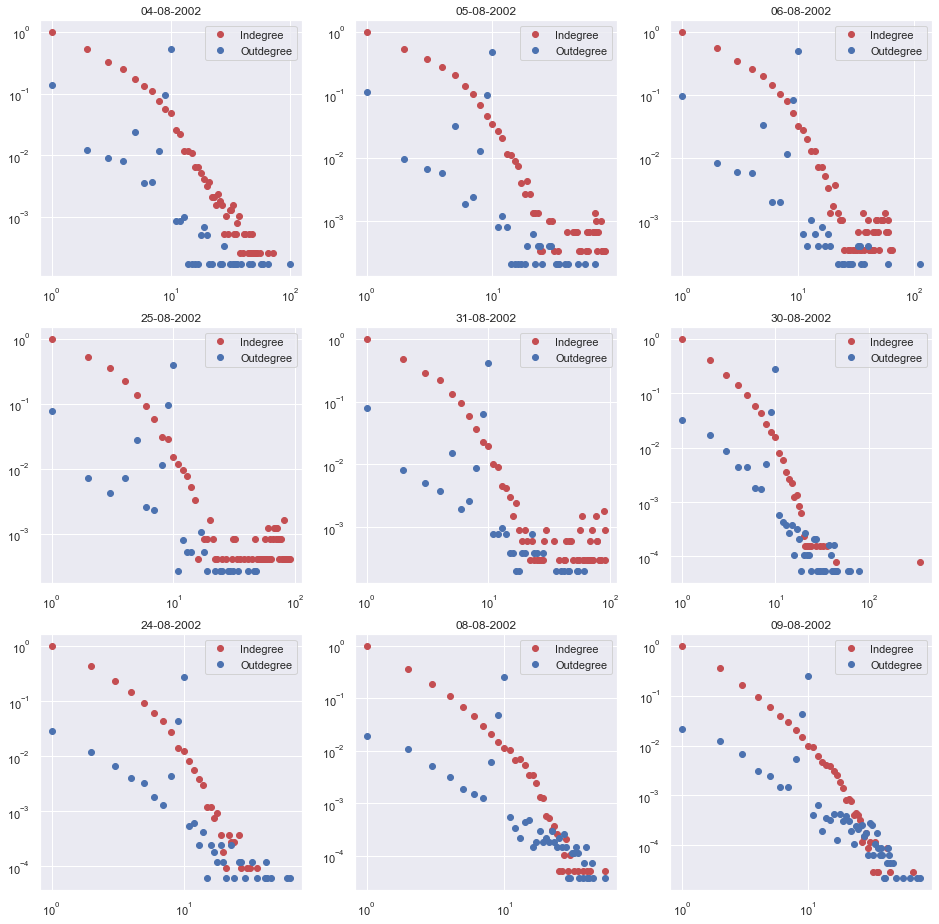

In [168]:
def degdist(ay, i):
    indeg = D[i]['degs']['in']; indeg[1] = [d / max(indeg[1]) for d in indeg[1]]
    outdeg = D[i]['degs']['out']; outdeg[1] = [d / max(outdeg[1]) for d in outdeg[1]]
    ay.loglog(indeg[0], indeg[1], 'ro', label='Indegree')
    ay.loglog(outdeg[0], outdeg[1], 'bo', label='Outdegree')

plotter("degdist(ay, i)")                            # function call line for previously defined plotter function

As can be seen there is a spike in outdegree frequency around 10. This looks highly artificial to us. One possible explanation of the spike could be that of it being an artifact of the way the network was crawled. However, this remains speculation. The spike too is present when plotting the clustering coefficient, and is also present for the configuration model:

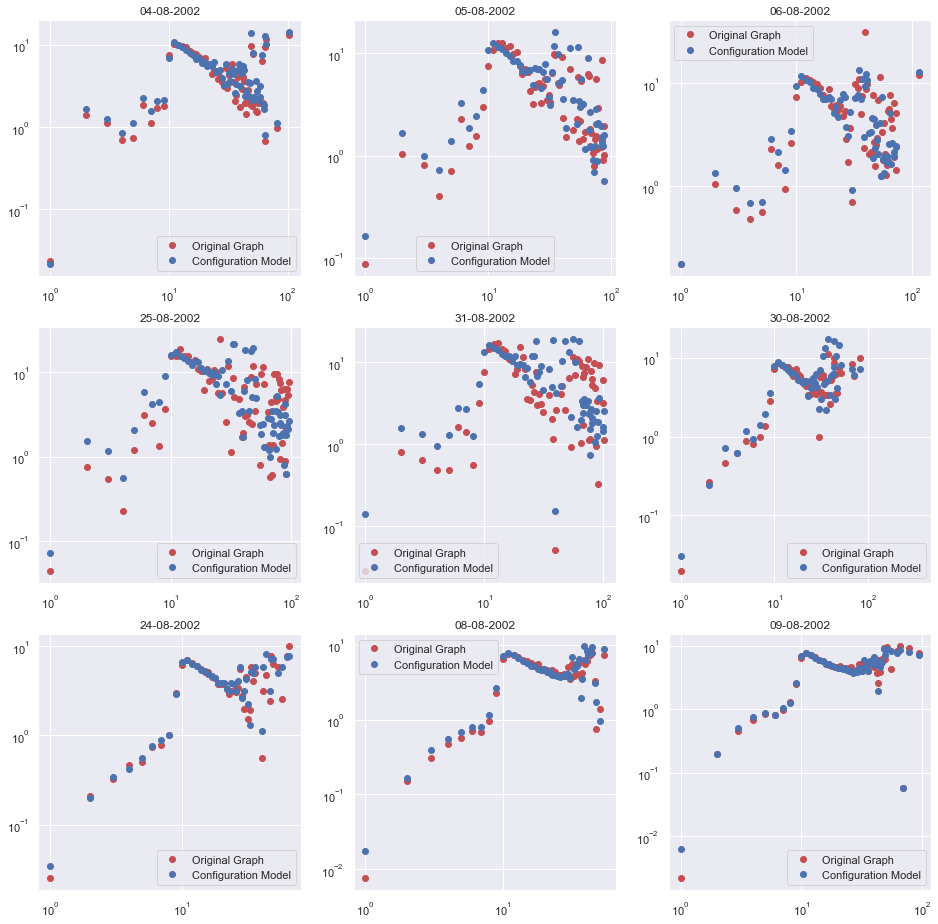

In [169]:
def cluster(ay, i):
    gx, gy = D[i]['knn']
    cx, cy = D[i]['C']['knn']
    ay.loglog(gx, gy, 'ro', label='Original Graph')
    ay.loglog(cx, cy, 'bo', label='Configuration Model')

plotter('cluster(ay, i)')           # execute clustering plot

There too seems to be a spike around 10 for the knn plot, echoing that of the degree distribution. However, the reason
for this still remains unknown. This spike might subtract from the quality of the network.

<a id='fitting'></a>
### Fitting


As the degree distribution for our network looks similar like that of a scale-free network, we want to check for this with fitting. If we can determine which fit our network follows, we can assume it inherents the same properties thus giving us a better understanding of our network.


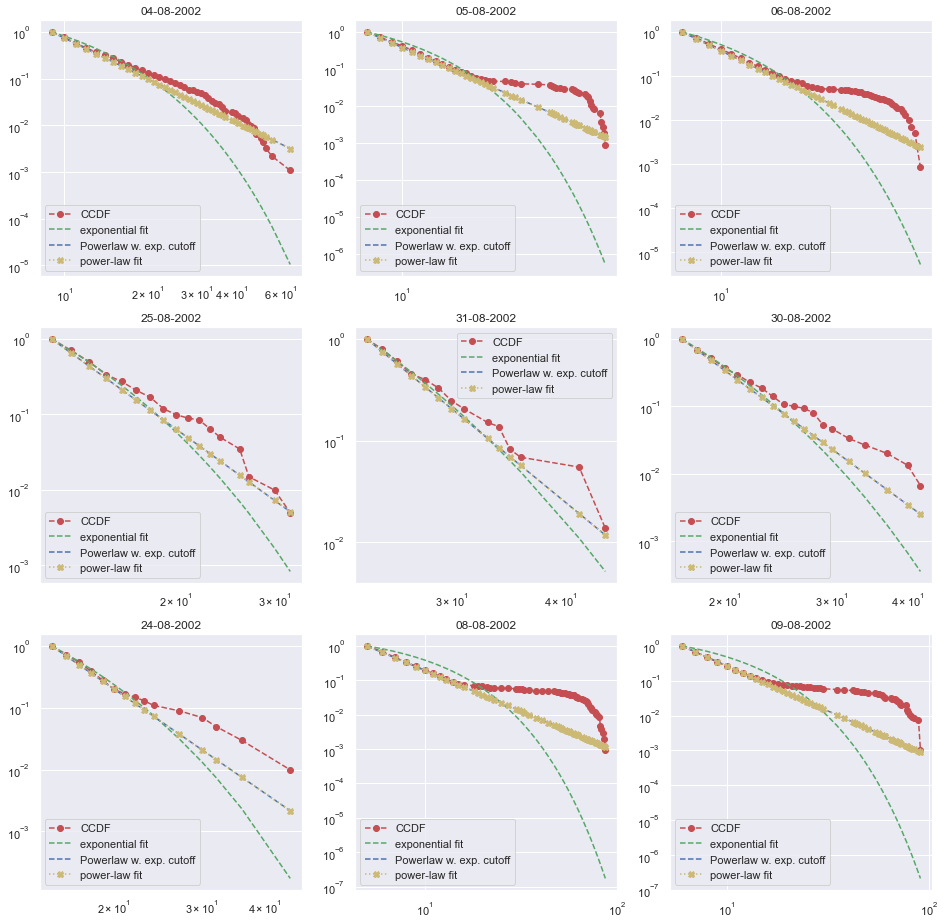

In [182]:
def fitting(ay, i):
    degs = np.array(list(dict(S[i].in_degree).values()))
    mask = (degs != max(degs))
    degs = degs[mask]
    fit = powerlaw.Fit(degs, ax=ay, verbose=False)
    fit.plot_ccdf(ax=ay, label='CCDF', color='r', linestyle='--', marker='o')
    fit.exponential.plot_ccdf(ax=ay, color='g', linestyle='--', label='exponential fit')
    fit.truncated_power_law.plot_ccdf(ax=ay, color='b', linestyle='--', label='Powerlaw w. exp. cutoff')
    fit.power_law.plot_ccdf(ax=ay, color='y', linestyle=':', label='power-law fit', marker='X')
    #fit.lognormal.plot_ccdf(ax=ay, color='c', linestyle='--', label='log-normal fit')
    # no log normal fit due to underflow error https://github.com/jeffalstott/powerlaw/pull/23
    
warnings.filterwarnings("ignore")   # get rid of annoying warnings
plotter('fitting(ay, i)')           # execute fitting plot

Looking at the plot, one thing is certain: The degree distribution does not follow an exponential fit. For the three others, log-normal, power-law and truncated power law fit, all describe the network quite well. The network does then indeed look to be scale free, as can be expected of real world networks.

<a id='centrality'></a>
### Centrality Measuress


At the time of crawling the network, two gnutella protocols were in fact in place (0.4 and 0.6)
0.4 used query flooding and 0.6 used query routing. It is in unlcear to us what protocol
was running on the nodes in our network. The different protocol does change the light through which
the following measures should be viewed. This we keep both protocols in mind.

As the plotting of centrality measures are largely the same we make a function to be used in all three cases:

In [74]:
def centrality(kind, ay, i):
    orignal = D[i]['centrality'][kind]
    config = D[i]['C']['centrality'][kind]
    ay.plot(orignal[0], orignal[1], 'ro', label='Original Graph')
    ay.plot(config[0], config[1], 'bo', label='Configuration Model')

Together with the centrality measurements for our data, we will plot the measurements of a configuration model made from our network. This is done to figure out to what extent the network's centrality measures are idiosyncratic to the network itself (as opposed to being a consequence of the degree distribution). A configuration model is a good tool for this as it has the same degree distribution as the one it is built from, but the given edges from a node are drawn to random nodes. If the centrality plots from the Gnutella network follows that of the configuration model plots, we can assume edges are made randomly.


<a id='betweenness'></a>
#### Betweenness centrality

The betweenness centrality of a node a, describes how large a portion of the shortest paths between any two other nodes, b and c, go through a. We plot this measure as we believe it intersting from the perspective of robustness.

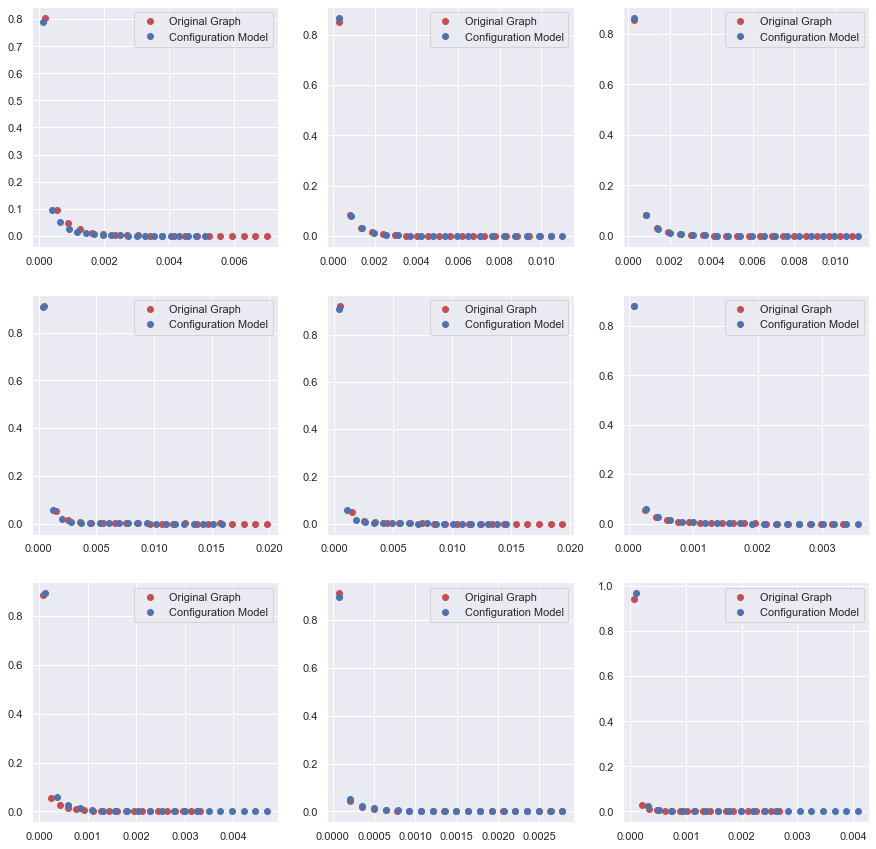

In [75]:
plotter('centrality("betweenness", ay, i)')

<a id='closeness'></a>
#### Closeness centrality

For both query routing and query flooding, the closeness centrality is a relevant metric, because both requests have a Time To Live (TTL) of 6. Thus any file present on a node further away than that would be unavailable to a node.


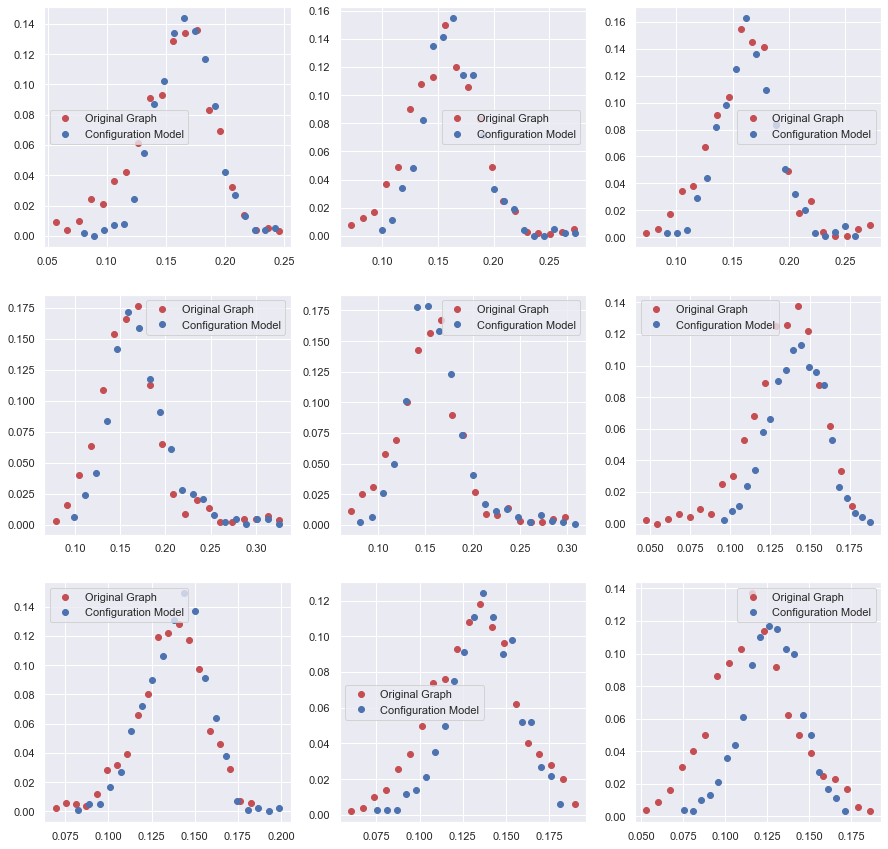

In [76]:
plotter('centrality("closeness", ay, i)')

<a id='eigenvector'></a>
#### Eigen vector centrality

To the extent that the network is using query flooding to find files, closeness centrality is essential.
Therefor we have plotted it here.

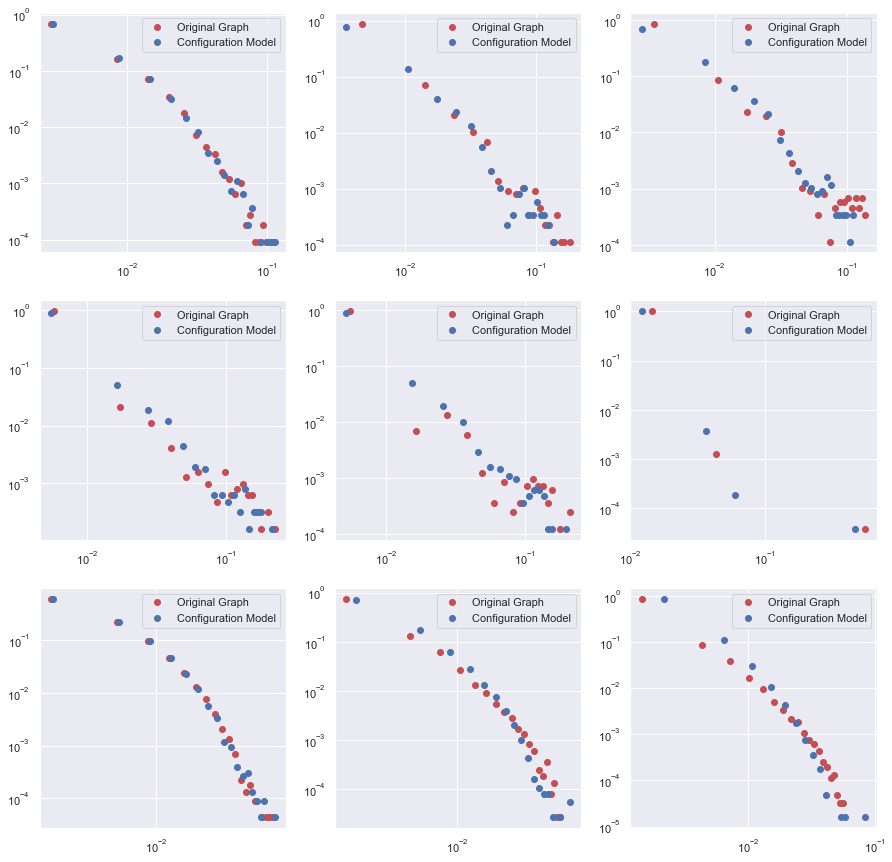

In [13]:
plotter('centrality("eigenvector", ay, i)')

<a id='robustness'></a>
### Robustness


Cursory research on the Gnutella network describes it as inefficient and problematic
Robustness is thus intersting

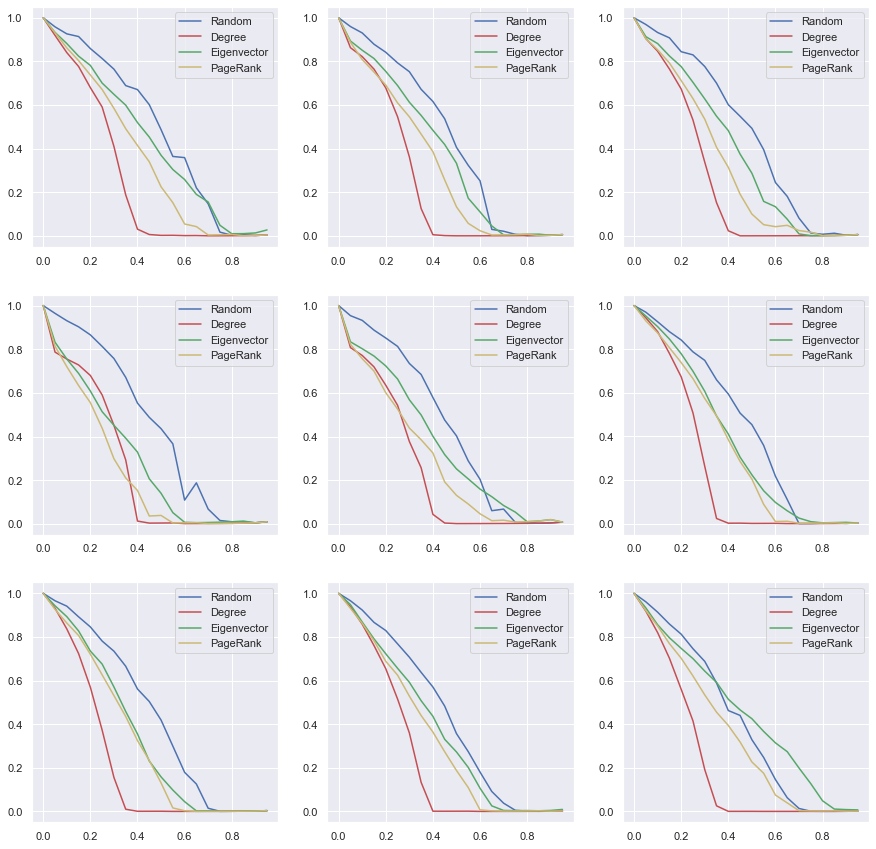

In [14]:
def robustness(ay, i):
    kinds = ['Random', 'Degree', 'Eigenvector', 'PageRank']; colors = 'brgy'
    G = D[i]['attack']
    for j in range(len(G) - 1):
        exec(f"ay.plot(G[-1], G[j], colors[j], label='{kinds[j]}')")

plotter('robustness(ay, i)')

We thus see that the network is relatively robust to random attacks, while siginificantly less so to degree based attacks, with Eigenvedtor and PageRank attacks lying somewhere in beteween. This particular desription of the networks sensitivty was not true for day 4 and 9, though the pattern holds.

We also attacked edges, by a random and a targeted approach.

<a id='future'></a>
## Future Work

Though the robustness tests run above are intersting from a network
analytical perspective, practically speaking, it might be more appropriate
to run a simulation that entailed starting multiple BFSs at random
nodes in the network



